<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/Bert_FCNN/TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import h5py
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/AnastasiaKazanas/ANN-Final-Project.git

Cloning into 'ANN-Final-Project'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (292/292), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 377 (delta 123), reused 191 (delta 100), pack-reused 85 (from 1)
Receiving objects: 100% (377/377), 61.62 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Filtering content: 100% (4/4), 435.85 MiB | 35.30 MiB/s, done.


In [4]:
file_path = '/content/ANN-Final-Project/Bert_embeding_datasets/Twitter.h5'

with h5py.File(file_path, 'r') as f:
    input_ids = torch.tensor(f['input_ids'][:], dtype=torch.float32)
    attention_masks = torch.tensor(f['attention_mask'][:], dtype=torch.float32)
    labels = torch.tensor(f['labels'][:], dtype=torch.long)
    texts = f['texts'][:]

# Train-test split
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

# Create DataLoaders
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        combined_input = torch.cat((input_ids, attention_mask), dim=1)
        x = self.fc1(combined_input)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model setup
input_size = input_ids.shape[1]
hidden_size = 128
num_classes = 2

model = FCNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input_ids_batch, mask_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids_batch, mask_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 13974.4889
Epoch 2/5, Loss: 2391.7049
Epoch 3/5, Loss: 2336.0568
Epoch 4/5, Loss: 2310.9884
Epoch 5/5, Loss: 2311.0483


Accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

       False       0.50      0.00      0.00     12955
        True       0.51      1.00      0.68     13688

    accuracy                           0.51     26643
   macro avg       0.51      0.50      0.34     26643
weighted avg       0.51      0.51      0.35     26643



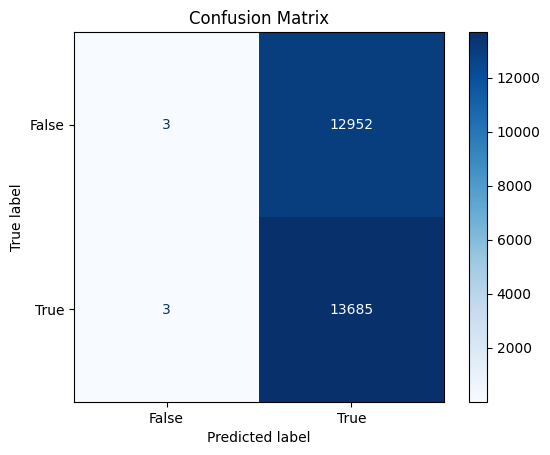

In [6]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for input_ids_batch, mask_batch, labels_batch in test_loader:
        outputs = model(input_ids_batch, mask_batch)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(labels_batch.tolist())
        y_pred.extend(preds.tolist())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["False", "True"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["False", "True"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()